In [1]:
!pip install transformers
!pip install huggingface_hub
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 36.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Personal Transformer
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
raw_datasets = load_dataset("ashwinradhe/dl_dataset")
small_train_dataset = raw_datasets['train'].select(range(100000))
SRC_LANGUAGE = "en"
TRG_LANGUAGE = "fr"
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
tokenizer_fr= get_tokenizer('spacy', language='fr_core_news_sm')
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
def tokenize_and_build_vocab(data, tokenizer):
    tokenized_data = [tokenizer(sentence) for sentence in data]
    vocab = build_vocab_from_iterator(tokenized_data,min_freq=1, specials=special_symbols,special_first=True)
    vocab.set_default_index(vocab['<unk>'])
    return vocab, tokenized_data
vocab_en, tokenized_data_en = tokenize_and_build_vocab(small_train_dataset['English Sentence'], tokenizer_en)
vocab_fr, tokenized_data_fr = tokenize_and_build_vocab(small_train_dataset['French Sentence'], tokenizer_fr)
def numericalize_and_pad(tokenized_data, vocab):
    numericalized_data = [torch.tensor(vocab.lookup_indices(sentence)) for sentence in tokenized_data]
    padded_data = pad_sequence(numericalized_data, batch_first=True, padding_value=vocab['<pad>'])
    return padded_data
padded_data_en = numericalize_and_pad(tokenized_data_en, vocab_en)
padded_data_fr = numericalize_and_pad(tokenized_data_fr, vocab_fr)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1825077 [00:00<?, ? examples/s]

In [4]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
dataset = torch.utils.data.TensorDataset(padded_data_en, padded_data_fr)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

##Absolute positional Encoding

In [ ]:
import torch
from torch import nn, Tensor
import math
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_fn, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0

        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss, validation_loss,model = train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 5.0618, Validation Loss: 4.4694
Epoch 2, Training Loss: 4.3250, Validation Loss: 4.2085
Epoch 3, Training Loss: 4.0804, Validation Loss: 4.0437
Epoch 4, Training Loss: 3.9067, Validation Loss: 3.9199
Epoch 5, Training Loss: 3.7722, Validation Loss: 3.8520
Epoch 6, Training Loss: 3.6624, Validation Loss: 3.7792
Epoch 7, Training Loss: 3.5732, Validation Loss: 3.7421
Epoch 8, Training Loss: 3.5007, Validation Loss: 3.7064
Epoch 9, Training Loss: 3.4402, Validation Loss: 3.7006
Epoch 10, Training Loss: 3.3885, Validation Loss: 3.6890


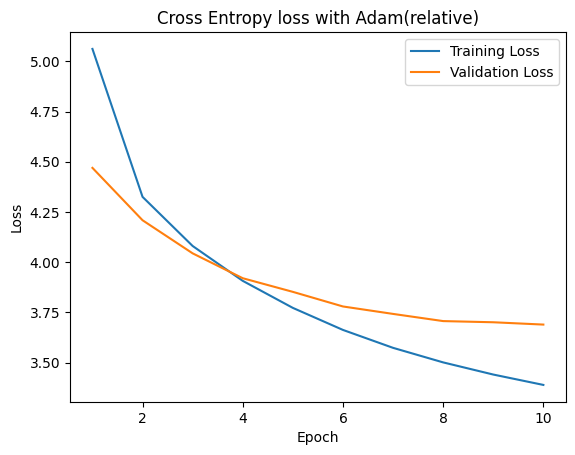

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Cross Entropy loss with Adam(relative)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_metrics = {"training_loss": training_loss, "validation_loss":validation_loss}
torch.save(model_metrics, '/content/drive/MyDrive/Adam/absolute_positional_encoding/crossentropyloss/model_metrics.pkl')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Adam/absolute_positional_encoding/crossentropyloss/model_weights.pt')
torch.save(model, '/content/drive/MyDrive/Adam/absolute_positional_encoding/crossentropyloss/model.pkl')

##Cross Entropy Loss with label smoothning

In [ ]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_cel = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.Adam(model_cel.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_cel = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.5)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cel.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_cel(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_cel(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_cel, validation_loss_cel,model_cel = train_and_evaluate(model_cel, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_cel, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 8.3896, Validation Loss: 8.2259
Epoch 2, Training Loss: 8.1165, Validation Loss: 8.1102
Epoch 3, Training Loss: 8.0286, Validation Loss: 7.9921
Epoch 4, Training Loss: 7.9652, Validation Loss: 7.9271
Epoch 5, Training Loss: 7.9184, Validation Loss: 7.8850
Epoch 6, Training Loss: 7.8825, Validation Loss: 7.8503
Epoch 7, Training Loss: 7.8552, Validation Loss: 7.8288
Epoch 8, Training Loss: 7.8312, Validation Loss: 7.8147
Epoch 9, Training Loss: 7.8085, Validation Loss: 7.8138
Epoch 10, Training Loss: 7.7869, Validation Loss: 7.8120


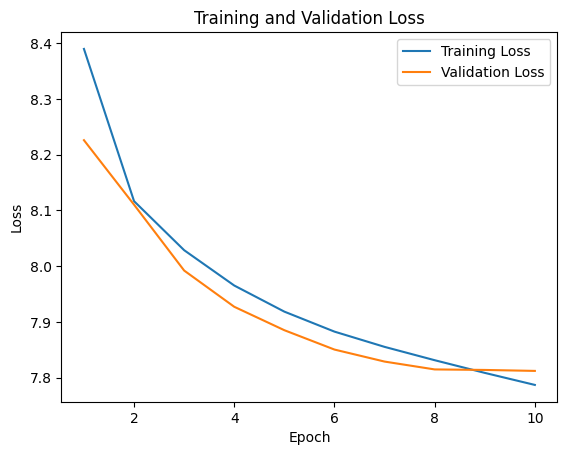

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_cel) + 1)
plt.plot(epochs,training_loss_cel, label='Training Loss')
plt.plot(epochs,validation_loss_cel, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
model_metrics_cel = {'training_loss':training_loss_cel, 'validation_loss':validation_loss_cel}
torch.save(model_metrics_cel, '/content/drive/MyDrive/Adam/absolute_positional_encoding/crossentropywithlabelsmoothning/model_metrics_cel.pkl')

In [ ]:
torch.save(model_cel, '/content/drive/MyDrive/Adam/absolute_positional_encoding/crossentropywithlabelsmoothning/model_cel.pt')
torch.save(model_cel.state_dict(), '/content/drive/MyDrive/Adam/absolute_positional_encoding/crossentropywithlabelsmoothning/model_cel_state_dict.pkl')

##Log Softmax + NLLLoss

In [5]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sc = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
optimizer = torch.optim.Adam(model_sc.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sc = nn.NLLLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sc.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            logits = torch.log_softmax(logits, dim=-1)
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sc(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0

        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                logits = torch.log_softmax(logits, dim=-1)
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sc(logits, tgt_output)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sc, validation_loss_sc,model_sc = train_and_evaluate(model_sc, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sc, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 5.0580, Validation Loss: 4.4734
Epoch 2, Training Loss: 4.3210, Validation Loss: 4.2566
Epoch 3, Training Loss: 4.0790, Validation Loss: 4.0528
Epoch 4, Training Loss: 3.9112, Validation Loss: 3.9404
Epoch 5, Training Loss: 3.7791, Validation Loss: 3.9107
Epoch 6, Training Loss: 3.6750, Validation Loss: 3.9133
Epoch 7, Training Loss: 3.5887, Validation Loss: 3.8465
Epoch 8, Training Loss: 3.5171, Validation Loss: 3.8641
Epoch 9, Training Loss: 3.4571, Validation Loss: 3.8583
Epoch 10, Training Loss: 3.4049, Validation Loss: 3.8494


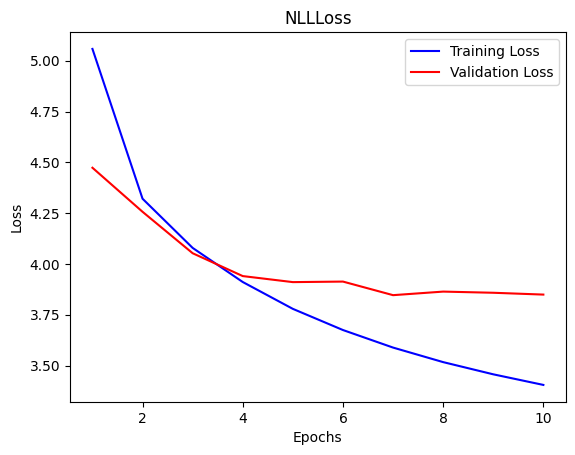

In [7]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sc) + 1)
plt.plot(epochs, training_loss_sc, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_sc, 'r', label='Validation Loss')
plt.title('NLLLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
model_metrics_sc = {'training_loss':training_loss_sc, 'validation_loss':validation_loss_sc}
torch.save(model_metrics_sc, '/content/drive/MyDrive/Adam/absolute_positional_encoding/sparsecategoricalcrossentropy/model_metrics_sc.pkl')

In [9]:
torch.save(model_sc.state_dict(), '/content/drive/MyDrive/Adam/absolute_positional_encoding/sparsecategoricalcrossentropy/model_weights_sc.pkl')
torch.save(model_sc, '/content/drive/MyDrive/Adam/absolute_positional_encoding/sparsecategoricalcrossentropy/model_sc.pt')

##Optimizer AdamW
##Cross Entropy Loss

In [20]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_adamw = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
optimizer = torch.optim.AdamW(model_adamw.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_adamw = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_adamw(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0

        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_adamw(logits, tgt_output)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_adamw, validation_loss_adamw,model_adamw = train_and_evaluate(model_adamw, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_adamw, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 5.0626, Validation Loss: 4.4610
Epoch 2, Training Loss: 4.3176, Validation Loss: 4.1961
Epoch 3, Training Loss: 4.0627, Validation Loss: 4.0047
Epoch 4, Training Loss: 3.8816, Validation Loss: 3.8575
Epoch 5, Training Loss: 3.7425, Validation Loss: 3.7609
Epoch 6, Training Loss: 3.6354, Validation Loss: 3.6972
Epoch 7, Training Loss: 3.5489, Validation Loss: 3.6466
Epoch 8, Training Loss: 3.4781, Validation Loss: 3.5991
Epoch 9, Training Loss: 3.4148, Validation Loss: 3.5743
Epoch 10, Training Loss: 3.3609, Validation Loss: 3.5234


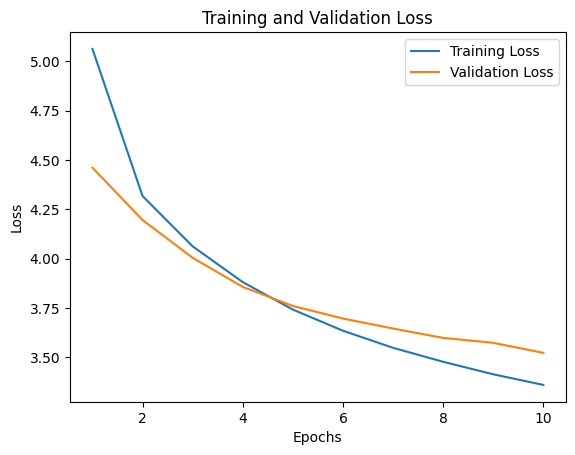

In [22]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_adamw) + 1)
plt.plot(epochs, training_loss_adamw, label='Training Loss')
plt.plot(epochs, validation_loss_adamw, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [23]:
model_adamw_metrics = {'training_loss': training_loss_adamw, 'validation_loss': validation_loss_adamw}
torch.save(model_adamw_metrics, '/content/drive/MyDrive/Adamw/absolute_positional_encoding/crossentropyloss/model_adamw_metrics.pkl')

In [24]:
torch.save(model_adamw.state_dict(), '/content/drive/MyDrive/Adamw/absolute_positional_encoding/crossentropyloss/model_metrics_adamw.pkl')
torch.save(model_adamw, '/content/drive/MyDrive/Adamw/absolute_positional_encoding/crossentropyloss/model_adamw.pt')


##Crossentropywithlabelsmoothning

In [ ]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_adamw_c = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.AdamW(model_adamw_c.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_adamw_c = nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.5)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw_c.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)


            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_adamw_c(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_adamw_c(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_adamw_c, validation_loss_adamw_c,model_adamw_c = train_and_evaluate(model_adamw_c, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_adamw_c, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 8.3907, Validation Loss: 8.1435
Epoch 2, Training Loss: 8.1149, Validation Loss: 8.0282
Epoch 3, Training Loss: 8.0165, Validation Loss: 7.9373
Epoch 4, Training Loss: 7.9435, Validation Loss: 7.8801
Epoch 5, Training Loss: 7.8930, Validation Loss: 7.8346
Epoch 6, Training Loss: 7.8543, Validation Loss: 7.8023
Epoch 7, Training Loss: 7.8234, Validation Loss: 7.7761
Epoch 8, Training Loss: 7.7985, Validation Loss: 7.7524
Epoch 9, Training Loss: 7.7775, Validation Loss: 7.7359
Epoch 10, Training Loss: 7.7585, Validation Loss: 7.7221


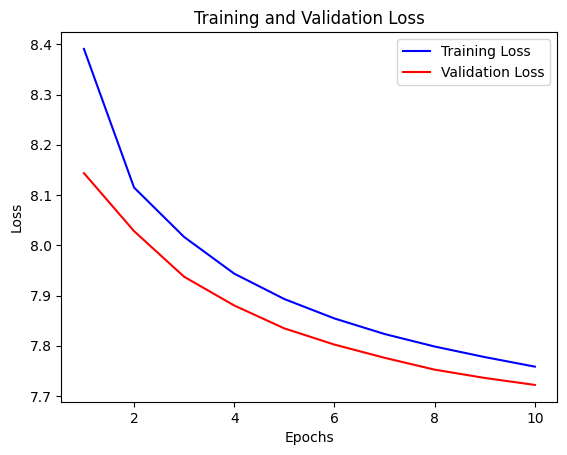

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_adamw_c) + 1)
plt.plot(epochs, training_loss_adamw_c, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_adamw_c, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_metrcis_adamw_c = {'training_loss': training_loss_adamw_c, 'validation_loss': validation_loss_adamw_c}
torch.save(model_metrcis_adamw_c, '/content/drive/MyDrive/Adamw/absolute_positional_encoding/crossentropywithlabelsmoothning/model_metrics_adamw_c.pkl')

In [ ]:
torch.save(model_adamw_c.state_dict(), '/content/drive/MyDrive/Adamw/absolute_positional_encoding/crossentropywithlabelsmoothning/model_state_adamw_c.pkl')
torch.save(model_adamw_c, '/content/drive/MyDrive/Adamw/absolute_positional_encoding/crossentropywithlabelsmoothning/model_adamw_c.pt')

##NLLLoss

In [10]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_adamw_n = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
optimizer = torch.optim.AdamW(model_adamw_n.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_adamw_n = nn.NLLLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw_n.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            logits = torch.log_softmax(logits, dim=-1)
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_adamw_n(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                logits = torch.log_softmax(logits, dim=-1)
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_adamw_n(logits, tgt_output)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_adamw_n, validation_loss_adamw_n,model_adamw_n = train_and_evaluate(model_adamw_n, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_adamw_n, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 5.0551, Validation Loss: 4.4479
Epoch 2, Training Loss: 4.3120, Validation Loss: 4.1679
Epoch 3, Training Loss: 4.0525, Validation Loss: 4.0123
Epoch 4, Training Loss: 3.8660, Validation Loss: 3.9337
Epoch 5, Training Loss: 3.7231, Validation Loss: 3.9439
Epoch 6, Training Loss: 3.6124, Validation Loss: 3.8991
Epoch 7, Training Loss: 3.5246, Validation Loss: 3.8740
Epoch 8, Training Loss: 3.4529, Validation Loss: 3.8582
Epoch 9, Training Loss: 3.3939, Validation Loss: 3.8466
Epoch 10, Training Loss: 3.3433, Validation Loss: 3.8359


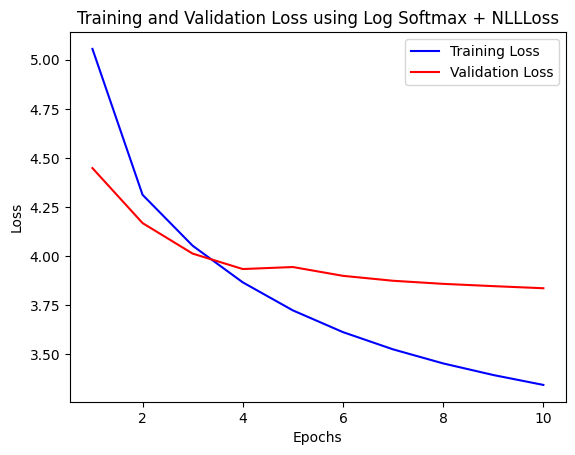

In [12]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_adamw_n) + 1)
plt.plot(epochs, training_loss_adamw_n, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_adamw_n, 'r', label='Validation Loss')
plt.title('Training and Validation Loss using Log Softmax + NLLLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
torch.save(model_adamw_n.state_dict(), '/content/drive/MyDrive/Adamw/absolute_positional_encoding/sparsecategoricalcrossentropy/model_metrics_adamw_n.pt')
torch.save(model_adamw_n, '/content/drive/MyDrive/Adamw/absolute_positional_encoding/sparsecategoricalcrossentropy/model_adamw_n.pkl')

In [14]:
model_metrics_adamw_n = {'training_loss':training_loss_adamw_n,'validation_loss':validation_loss_adamw_n}
torch.save(model_metrics_adamw_n, '/content/drive/MyDrive/Adamw/absolute_positional_encoding/sparsecategoricalcrossentropy/model_adamw_n_metrics.pt')

##SGD

##Cross Entropy Loss

In [ ]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sgd = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sgd = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sgd.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sgd(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sgd(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sgd, validation_loss_sgd,model_sgd = train_and_evaluate(model_sgd, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sgd, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 9.9171, Validation Loss: 8.9891
Epoch 2, Training Loss: 8.4948, Validation Loss: 8.0861
Epoch 3, Training Loss: 7.9001, Validation Loss: 7.7241
Epoch 4, Training Loss: 7.6258, Validation Loss: 7.5231
Epoch 5, Training Loss: 7.4561, Validation Loss: 7.3773
Epoch 6, Training Loss: 7.3198, Validation Loss: 7.2504
Epoch 7, Training Loss: 7.2026, Validation Loss: 7.1432
Epoch 8, Training Loss: 7.1036, Validation Loss: 7.0520
Epoch 9, Training Loss: 7.0172, Validation Loss: 6.9682
Epoch 10, Training Loss: 6.9344, Validation Loss: 6.8800


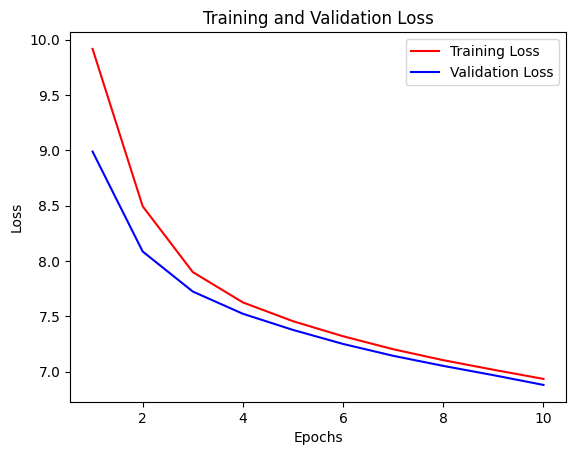

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sgd) + 1)
plt.plot(epochs, training_loss_sgd, 'r', label='Training Loss')
plt.plot(epochs, validation_loss_sgd, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_sgd_metrics = {'training_loss': training_loss_sgd, 'validation_loss': validation_loss_sgd}
torch.save(model_sgd_metrics, '/content/drive/MyDrive/SGD/absolute_positional_encoding/crossentropyloss/model_sgd_metrics.pkl')

In [ ]:
torch.save(model_sgd, '/content/drive/MyDrive/SGD/absolute_positional_encoding/crossentropyloss/model_sgd.pt')
torch.save(model_sgd.state_dict(), '/content/drive/MyDrive/SGD/absolute_positional_encoding/crossentropyloss/model_sgd_state.pkl')

##With Label Smoothning

In [ ]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sgd_ls = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

In [ ]:
optimizer = torch.optim.SGD(model_sgd_ls.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sgd_ls = nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.1)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sgd_ls.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sgd_ls(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sgd_ls(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sgd_ls, validation_loss_sgd_ls,model_sgd_ls = train_and_evaluate(model_sgd_ls, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sgd_ls, epochs=10)

Epoch 1, Training Loss: 10.0608, Validation Loss: 9.2836
Epoch 2, Training Loss: 8.8122, Validation Loss: 8.4269
Epoch 3, Training Loss: 8.2468, Validation Loss: 8.0805
Epoch 4, Training Loss: 7.9874, Validation Loss: 7.8939
Epoch 5, Training Loss: 7.8325, Validation Loss: 7.7622
Epoch 6, Training Loss: 7.7110, Validation Loss: 7.6511
Epoch 7, Training Loss: 7.6107, Validation Loss: 7.5620
Epoch 8, Training Loss: 7.5298, Validation Loss: 7.4892
Epoch 9, Training Loss: 7.4624, Validation Loss: 7.4264
Epoch 10, Training Loss: 7.4027, Validation Loss: 7.3675


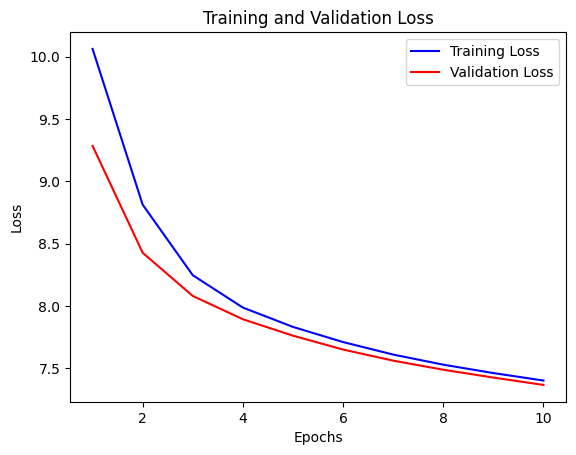

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sgd_ls) + 1)
plt.plot(epochs, training_loss_sgd_ls, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_sgd_ls, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model_sgd_ls.state_dict(), '/content/drive/MyDrive/SGD/absolute_positional_encoding/crossentropywithlabelsmoothning/model_sgd_ls_state.pkl')
torch.save(model_sgd_ls, '/content/drive/MyDrive/SGD/absolute_positional_encoding/crossentropywithlabelsmoothning/model_sgd_ls.pt')

In [ ]:
model_sgd_ls_metrics = {'training_loss':training_loss_sgd_ls,'validation_loss':validation_loss_sgd_ls}
torch.save(model_sgd_ls_metrics, '/content/drive/MyDrive/SGD/absolute_positional_encoding/crossentropywithlabelsmoothning/model_sgd_ls_metrics.pkl')

##NLLLosss

In [15]:
import torch
from torch import nn, Tensor
import math

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=0.1, maxlen=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=device)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sgd_n = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
optimizer = torch.optim.SGD(model_sgd_n.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sgd_n = nn.NLLLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sgd_n.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            logits = torch.log_softmax(logits, dim=-1)
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sgd_n(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                logits = torch.log_softmax(logits, dim=-1)
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sgd_n(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sgd_n, validation_loss_sgd_n,model_sgd_n = train_and_evaluate(model_sgd_n, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sgd_n, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 9.9108, Validation Loss: 9.0005
Epoch 2, Training Loss: 8.5167, Validation Loss: 8.1189
Epoch 3, Training Loss: 7.9378, Validation Loss: 7.7663
Epoch 4, Training Loss: 7.6747, Validation Loss: 7.5762
Epoch 5, Training Loss: 7.5200, Validation Loss: 7.4503
Epoch 6, Training Loss: 7.4058, Validation Loss: 7.3459
Epoch 7, Training Loss: 7.3067, Validation Loss: 7.2500
Epoch 8, Training Loss: 7.2146, Validation Loss: 7.1560
Epoch 9, Training Loss: 7.1198, Validation Loss: 7.0488
Epoch 10, Training Loss: 7.0163, Validation Loss: 6.9451


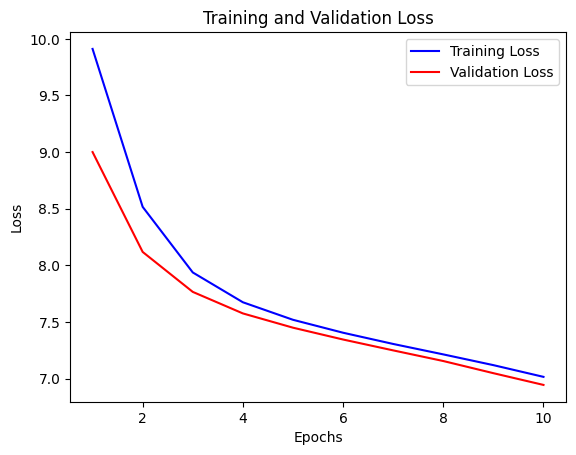

In [17]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sgd_n) + 1)
plt.plot(epochs, training_loss_sgd_n, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_sgd_n, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
torch.save(model_sgd_n.state_dict(), '/content/drive/MyDrive/SGD/absolute_positional_encoding/sparsecategoricalcrossentropy/model_sgd_n_state.pkl')
torch.save(model_sgd_n, '/content/drive/MyDrive/SGD/absolute_positional_encoding/sparsecategoricalcrossentropy/model_sgd_n.pt')

In [19]:
model_sgd_n_metrics = {'training loss': training_loss_sgd_n, 'validation loss': validation_loss_sgd_n}
torch.save(model_sgd_n_metrics, '/content/drive/MyDrive/SGD/absolute_positional_encoding/sparsecategoricalcrossentropy/model_sgd_n_metrics.pkl')